In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import unicodedata
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification

In [3]:
# Tải mô hình và tokenizer
model_name = "peterhung/vietnamese-accent-marker-xlm-roberta"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
model = AutoModelForTokenClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/24.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

In [4]:
# Upload file tags
from google.colab import files
print("Vui lòng upload file selected_tags_names.txt:")
uploaded = files.upload()

Vui lòng upload file selected_tags_names.txt:


Saving selected_tags_names.txt to selected_tags_names.txt


In [5]:
# Tải danh sách tags
def tai_danh_sach_tags(ten_file):
    """Tải danh sách tags từ file."""
    with open(ten_file, 'r', encoding='utf-8') as f:
        tags = [line.strip() for line in f.readlines()]
    return tags

# Tải tags
tags = tai_danh_sach_tags("selected_tags_names.txt")
print(f"Đã tải {len(tags)} tags")

Đã tải 528 tags


In [6]:
def ap_dung_nhan(token, nhan):
    """Áp dụng nhãn để khôi phục dấu cho token."""
    if '-' not in nhan:
        return token

    raw, co_dau = nhan.split('-', 1)
    if raw in token:
        return token.replace(raw, co_dau, 1)
    return token


def lam_sach_token(token):
    """Giữ lại token đặc biệt '▁' để khôi phục khoảng trắng."""
    if token in ['<s>', '</s>', '<pad>', '<unk>']:
        return ''
    return token  # Giữ nguyên để xử lý dấu cách sau


def detokenize(tokens):
    """Ghép lại các token đã khôi phục dấu dựa trên subword của XLM-RoBERTa."""
    text = ''
    for token in tokens:
        if token.startswith('▁'):
            text += ' ' + token[1:]  # dấu cách cho từ mới
        else:
            text += token  # phần tiếp nối của từ
    return text.strip()

def khoi_phuc_dau_tieng_viet(van_ban):
    """Khôi phục dấu tiếng Việt cho văn bản đầu vào."""
    print(f"Văn bản gốc: {van_ban}")

    # Tokenize văn bản
    inputs = tokenizer(van_ban, return_tensors="pt", truncation=True)

    # Dự đoán nhãn
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

    # Lấy danh sách token từ input_ids
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # Áp dụng nhãn và làm sạch
    tokens_khoi_phuc = []
    for token, pred in zip(tokens, predictions[0].tolist()):
        token_sach = lam_sach_token(token)
        if token_sach:  # Bỏ token rỗng
            nhan = tags[pred]
            token_co_dau = ap_dung_nhan(token_sach, nhan)
            tokens_khoi_phuc.append(token_co_dau)

    # Khôi phục văn bản từ tokens
    van_ban_co_dau = detokenize(tokens_khoi_phuc)
    print(f"Văn bản có dấu: {van_ban_co_dau}")
    return van_ban_co_dau


In [7]:
# Ví dụ
van_ban = "Hai ben khong ghi giay to, chi thoa thuan mieng vi toi da quen ong Tho hon 20 nam nay."
ket_qua = khoi_phuc_dau_tieng_viet(van_ban)

Văn bản gốc: Hai ben khong ghi giay to, chi thoa thuan mieng vi toi da quen ong Tho hon 20 nam nay.
Văn bản có dấu: Hai bên không ghi giay tờ, chỉ thoa thuan mieng vì tôi da quên ông Thợ hơn 20 năm nay.


#Đánh giá mô hình

In [37]:
import matplotlib.pyplot as plt
from nltk.metrics.distance import edit_distance

# Metrics calculation
def calculate_sentence_accuracy(results: list[dict]) -> float:
    if not results:
        return 0.0
    correct_sentences = 0
    for res in results:
        if res["true_accented"].strip() == res["predicted_accented"].strip():
            correct_sentences += 1
    return (correct_sentences / len(results)) * 100

def calculate_word_accuracy(results: list[dict]) -> float:
    if not results:
        return 0.0
    total_words = 0
    correct_words = 0
    for res in results:
        true_words = res["true_accented"].strip().split()
        predicted_words = res["predicted_accented"].strip().split()
        len_min = min(len(true_words), len(predicted_words))
        for i in range(len_min):
            if true_words[i] == predicted_words[i]:
                correct_words += 1
        total_words += len(true_words)
    if total_words == 0: return 0.0
    return (correct_words / total_words) * 100

def calculate_cer(results: list[dict]) -> float:
    if not results:
        return 0.0
    total_edit_distance = 0
    total_true_chars = 0
    for res in results:
        true_str = res["true_accented"].strip()
        pred_str = res["predicted_accented"].strip()
        if not true_str and not pred_str:
            dist = 0
        elif not true_str:
            dist = len(pred_str)
        elif not pred_str:
            dist = len(true_str)
        else:
            dist = edit_distance(pred_str, true_str)
        total_edit_distance += dist
        total_true_chars += len(true_str)
    if total_true_chars == 0: return 1.0 if total_edit_distance > 0 else 0.0
    return (total_edit_distance / total_true_chars) * 100

def display_sample_results(results: list[dict], num_samples: int = 5):
    print("\n--- Sample Predictions ---")
    for i, res in enumerate(results[:num_samples]):
        print(f"Sample {i+1}:")
        print(f"  Input:     '{res['input_unaccented']}'")
        print(f"  True:      '{res['true_accented']}'")
        print(f"  Predicted: '{res['predicted_accented']}'")
        print("---")

def plot_metrics(metrics: dict, filename: str = "evaluation_metrics_test.png"):
    try:
        names = list(metrics.keys())
        values = list(metrics.values())

        plt.figure(figsize=(10, 5))
        plt.bar(names, values, color=['skyblue'])
        plt.ylabel('Percentage (%)')
        plt.title('Model Evaluation Metrics')

        # Add values on top of each bar
        for i, value in enumerate(values):
            plt.text(i, value + 0.5, f"{value:.2f}%", ha='center')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"\nError plotting metrics: {e}")

def calculate_f1_score(results: list[dict]) -> float:
    """
    Calculate F1 score at word level.

    F1 = 2 * (precision * recall) / (precision + recall)
    where precision = TP/(TP+FP) and recall = TP/(TP+FN)
    """
    if not results:
        return 0.0

    total_tp, total_fp, total_fn = 0, 0, 0

    for res in results:
        true_words = res["true_accented"].strip().split()
        pred_words = res["predicted_accented"].strip().split()

        # Create sets for comparison
        true_set = set([(i, word) for i, word in enumerate(true_words)])
        pred_set = set([(i, word) for i, word in enumerate(pred_words) if i < len(true_words)])

        # Calculate TP, FP, FN
        tp = len(true_set.intersection(pred_set))
        fp = len(pred_set) - tp
        fn = len(true_set) - tp

        total_tp += tp
        total_fp += fp
        total_fn += fn

    # Calculate precision and recall
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1 * 100  # Return as percentage

def calculate_wer(results: list[dict]) -> float:
    return 100 - calculate_word_accuracy(results)

Đánh giá 1: đánh giá với 300 câu từ bộ dữ liệu

In [10]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.6 MB/s eta 0:00:00


In [11]:
#Tải dataset của mô hình
import requests, random
from unidecode import unidecode

url = "https://raw.githubusercontent.com/binhvq/news-corpus/master/sample/demo-full.txt"
res = requests.get(url)
demo_sentences = [l for l in res.text.splitlines() if l.strip()]

dataset_demo = [
    {"input_unaccented": unidecode(sent), "true_accented": sent}
    for sent in demo_sentences
]
sample_300 = random.sample(dataset_demo, min(300, len(dataset_demo)))


In [12]:
import re

def clean_pred(s: str) -> str:
    # 1. Nối các token con: xóa khoảng trắng trước dấu gạch nối, dấu câu
    s = re.sub(r"\s+([,.;:!?)])", r"\1", s)
    s = re.sub(r"([(])\s+", r"\1", s)
    # 2. Xóa khoảng trắng xung quanh các subword marker (nếu có)
    s = re.sub(r"\s+__", "", s)
    s = re.sub(r"##\s+", "", s)
    # 3. Chuẩn hóa nhiều khoảng trắng thành một
    return re.sub(r"\s{2,}", " ", s).strip()


In [10]:
import random
import matplotlib.pyplot as plt
def evaluate_on_dataset(dataset: list[dict], sample_size: int = 300):
    # Lấy ngẫu nhiên sample_size câu
    sample = random.sample(dataset, min(sample_size, len(dataset)))
    results = []
    for item in sample:
        # Sinh và làm sạch
        raw_pred = khoi_phuc_dau_tieng_viet(item["input_unaccented"])
        pred = clean_pred(raw_pred)
        results.append({
            "input_unaccented": item["input_unaccented"],
            "true_accented": item["true_accented"],
            "predicted_accented": pred
        })

    sent_acc = calculate_sentence_accuracy(results)
    word_acc = calculate_word_accuracy(results)
    cer = calculate_cer(results)
    char_acc = 100.0 - cer
    wer = calculate_wer(results)
    f1 = calculate_f1_score(results)

    labels = ['Sentence', 'Word', 'Character', 'F1', 'CER', 'WER']
    values = [sent_acc, word_acc, char_acc, f1, cer, wer]

    plt.style.use('default')
    plt.figure(figsize=(10,5))
    bars = plt.bar(labels, values, color=['skyblue'])
    plt.ylim(0, 100)
    plt.ylabel('Tỉ lệ (%) hoặc Error Rate (%)')
    plt.title('Đánh giá mô hình XLM_RoBERTa trên 300 câu')
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Thêm lưới ngang

    for i, v in enumerate(values):
        plt.text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')
    plt.show()

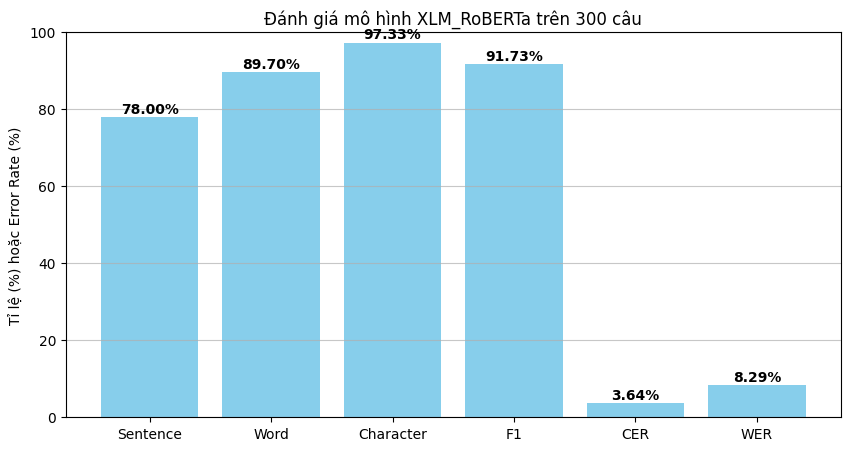

In [18]:

metrics_demo = evaluate_on_dataset(sample_300, sample_size=300)

In [40]:
# ---- Hàm evaluate_on_files ----
def evaluate_on_files(test_path: str, gold_path: str, sample_size: int = 300):
    with open(test_path, "r", encoding="utf-8") as f:
        inputs = [line.strip() for line in f if line.strip()]
    with open(gold_path, "r", encoding="utf-8") as f:
        trues = [line.strip() for line in f if line.strip()]

    n = min(sample_size, len(inputs), len(trues))
    results = []
    for i in range(n):
        inp = inputs[i]
        true = trues[i]
        raw_pred = khoi_phuc_dau_tieng_viet(inp)
        pred = clean_pred(raw_pred)
        results.append({
            "input_unaccented": inp,
            "true_accented": true,
            "predicted_accented": pred
        })

    sent_acc = calculate_sentence_accuracy(results)
    word_acc = calculate_word_accuracy(results)
    f1 = calculate_f1_score(results)
    wer = calculate_wer(results)
    cer = calculate_cer(results)
    char_acc = 100.0 - cer

    print(f"\n=== Evaluation 2: trên {n} câu từ {os.path.basename(test_path)} ===")
    print(f"{'Sentence Acc (%)':15s}: {sent_acc:6.2f}")
    print(f"{'Word Acc (%)':15s}: {word_acc:6.2f}")
    print(f"{'Char Acc (%)':15s}: {char_acc:6.2f}")
    print(f"{'F1 Score (%)':15s}: {f1:6.2f}")
    print(f"{'CER (%)':15s}: {wer:6.2f}")
    print(f"{'WER (%)':15s}: {wer:6.2f}")


    display_sample_results(results, num_samples=5)
    plot_metrics({
        "Sentence Acc (%)": sent_acc,
        "Word Acc (%)":    word_acc,
        "Char Acc (%)":    char_acc,
        "F1 Score (%)":    f1,
        "CER (%)"      : cer,
        "WER (%)":         wer
    }, filename="eval2_metrics.png")

    return {
        "Sentence Acc (%)": sent_acc,
        "Word Acc (%)":    word_acc,
        "Char Acc (%)":    char_acc,
        "F1 Score (%)":    f1,
        "CER (%)"      : cer,
        "WER (%)":         wer
    }

In [17]:
from google.colab import files
uploaded = files.upload()

Saving selected_tags_names.txt to selected_tags_names (1).txt


Văn bản gốc: bau troi hom nay rat dep
Văn bản có dấu: bầu troi hôm nay rất đẹp
Văn bản gốc: chung ta di an toi nhe
Văn bản có dấu: chúng ta đi ăn tối nhé
Văn bản gốc: toi muon uong mot ly ca phe
Văn bản có dấu: tôi muon uong một ly cà phê
Văn bản gốc: con chim dang hot tren cay cao
Văn bản có dấu: con chim đang hót trên cay cào
Văn bản gốc: cuon sach nay co noi dung hay
Văn bản có dấu: cuon sách này có nội dung hay
Văn bản gốc: ban co muon di xem phim khong
Văn bản có dấu: bạn có muon đi xem phim không
Văn bản gốc: ngay mai troi se mua to day
Văn bản có dấu: ngày mai troi sẽ mưa to dày
Văn bản gốc: toi cam thay hoi met mot chut
Văn bản có dấu: tôi cảm thấy hỏi mệt một chút
Văn bản gốc: chiec xe may cua toi bi hong roi
Văn bản có dấu: chiec xe máy cua tôi bị hỏng rơi
Văn bản gốc: chung ta nen tap the duc thuong xuyen
Văn bản có dấu: chúng ta nên tập thể dục thuong xuyen
Văn bản gốc: gia dinh la dieu quan trong nhat
Văn bản có dấu: gia đình là dieu quan trọng nhất
Văn bản gốc: chuc ban m

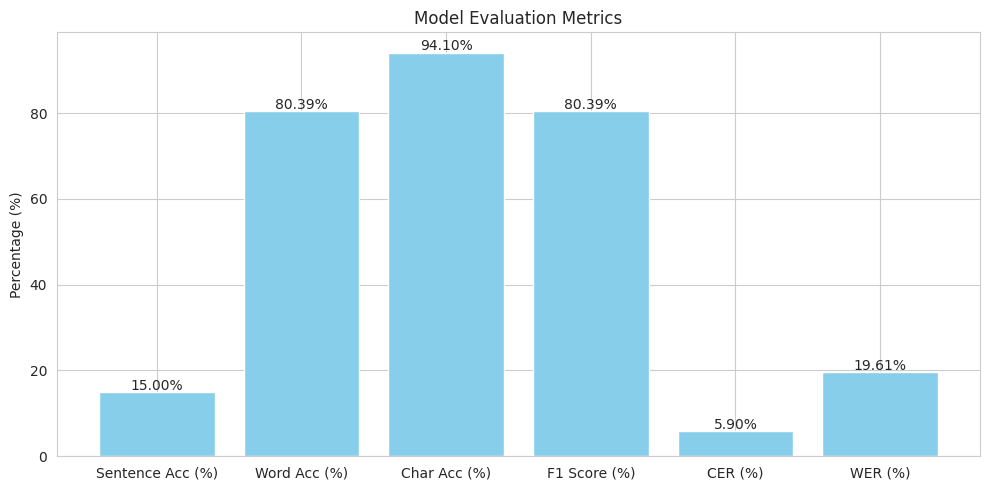


Metrics on test set: {'Sentence Acc (%)': 15.0, 'Word Acc (%)': 80.38621734191594, 'Char Acc (%)': 94.10410764872522, 'F1 Score (%)': 80.38621734191594, 'CER (%)': 5.895892351274788, 'WER (%)': 19.613782658084062}


In [41]:
import os
metrics2 = evaluate_on_files("test.txt", "test_result.txt", sample_size=300)
print("\nMetrics on test set:", metrics2)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------